In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 34.7 MB/s eta 0:00:00


In [2]:
# Import Library

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import faiss
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_path = "/content/drive/MyDrive/Capstone Project LaskarAI - Rizal Teddyansyah/Progress Report/Image Similarity/dataset.zip"
extract_path = "/content/dataset"  # tempat ekstraksi

In [5]:
import zipfile
import os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset berhasil diekstrak ke:", extract_path)

✅ Dataset berhasil diekstrak ke: /content/dataset


In [6]:
# ========== 1. LOAD ONE-HOT CSV TO LABEL FORMAT ==========
def load_onehot_df(subset_path):
    csv_path = os.path.join(subset_path, "_classes.csv")
    df = pd.read_csv(csv_path)
    df['label_index'] = df.iloc[:, 1:].values.argmax(axis=1)
    df['class'] = df.iloc[:, 1:].columns[df['label_index']]
    df['full_path'] = df['filename'].apply(lambda x: os.path.join(subset_path, x))
    df = df[df['full_path'].apply(os.path.exists)]
    return df[['filename', 'class', 'label_index', 'full_path']]

In [7]:
# ========== 2. SETUP MODEL & TRANSFORM ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


In [11]:
# ========== 3. EXTRACT FEATURES FROM IMAGE LIST ==========
def extract_features(df):
    feats, labels, paths = [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img = Image.open(row['full_path']).convert("RGB")
            tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = model(tensor).squeeze().cpu().numpy()
            feats.append(feat)
            labels.append(row['class'])
            paths.append(row['full_path'])
        except:
            continue
    return np.array(feats).astype("float32"), np.array(labels), np.array(paths)


In [12]:
# ========== 4. EVALUATE & VISUALIZE FROM CACHED FEATURES ==========
def evaluate_and_visualize_cached(
    test_feats, test_labels, test_paths,
    train_feats, train_labels, train_paths,
    top_k=3, sample_size=10
):
    index = faiss.IndexFlatL2(train_feats.shape[1])
    index.add(train_feats)

    correct_top1 = 0
    correct_topk = 0
    results_for_vis = []

    for i in range(len(test_feats)):
        feat = test_feats[i].reshape(1, -1)
        label_true = test_labels[i]
        path_query = test_paths[i]

        D, I = index.search(feat, top_k + 1)
        pred_labels = [train_labels[j] for j in I[0]]
        pred_paths = [train_paths[j] for j in I[0]]
        pred_dists = D[0]

        if label_true == pred_labels[1]:
            correct_top1 += 1
        if label_true in pred_labels[1:]:
            correct_topk += 1

        results_for_vis.append({
            "query_path": path_query,
            "query_label": label_true,
            "top_paths": pred_paths[1:],
            "top_labels": pred_labels[1:],
            "top_dists": pred_dists[1:]
        })

    # Accuracy summary
    total = len(test_feats)
    acc1 = correct_top1 / total if total else 0
    acck = correct_topk / total if total else 0
    print(f"\n🎯 Top-1 Accuracy : {acc1:.2%}")
    print(f"🎯 Top-{top_k} Accuracy : {acck:.2%}")

    # Visualisasi hasil
    print(f"\n📸 Menampilkan {sample_size} hasil secara acak...")
    samples = random.sample(results_for_vis, min(sample_size, total))
    n_cols = top_k + 1
    n_rows = len(samples)

    fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))
    img_idx = 1

    for item in samples:
        ax = fig.add_subplot(n_rows, n_cols, img_idx)
        ax.imshow(Image.open(item['query_path']))
        ax.axis('off')
        ax.set_title(f"Query\n{item['query_label']}", fontsize=10)
        img_idx += 1

        for k in range(top_k):
            pred_label = item['top_labels'][k]
            dist = item['top_dists'][k]
            ax = fig.add_subplot(n_rows, n_cols, img_idx)
            ax.imshow(Image.open(item['top_paths'][k]))
            ax.axis('off')
            color = 'green' if pred_label == item['query_label'] else 'red'
            ax.set_title(f"Top {k+1}\n{pred_label}\nL2: {dist:.2f}", fontsize=9, color=color)
            img_idx += 1

    plt.tight_layout()
    plt.show()


🚀 Ekstraksi fitur TRAIN


100%|██████████| 2740/2740 [08:29<00:00,  5.38it/s]



🚀 Ekstraksi fitur TEST


100%|██████████| 184/184 [00:33<00:00,  5.49it/s]



🎯 Top-1 Accuracy : 95.11%
🎯 Top-3 Accuracy : 97.83%

📸 Menampilkan 10 hasil secara acak...


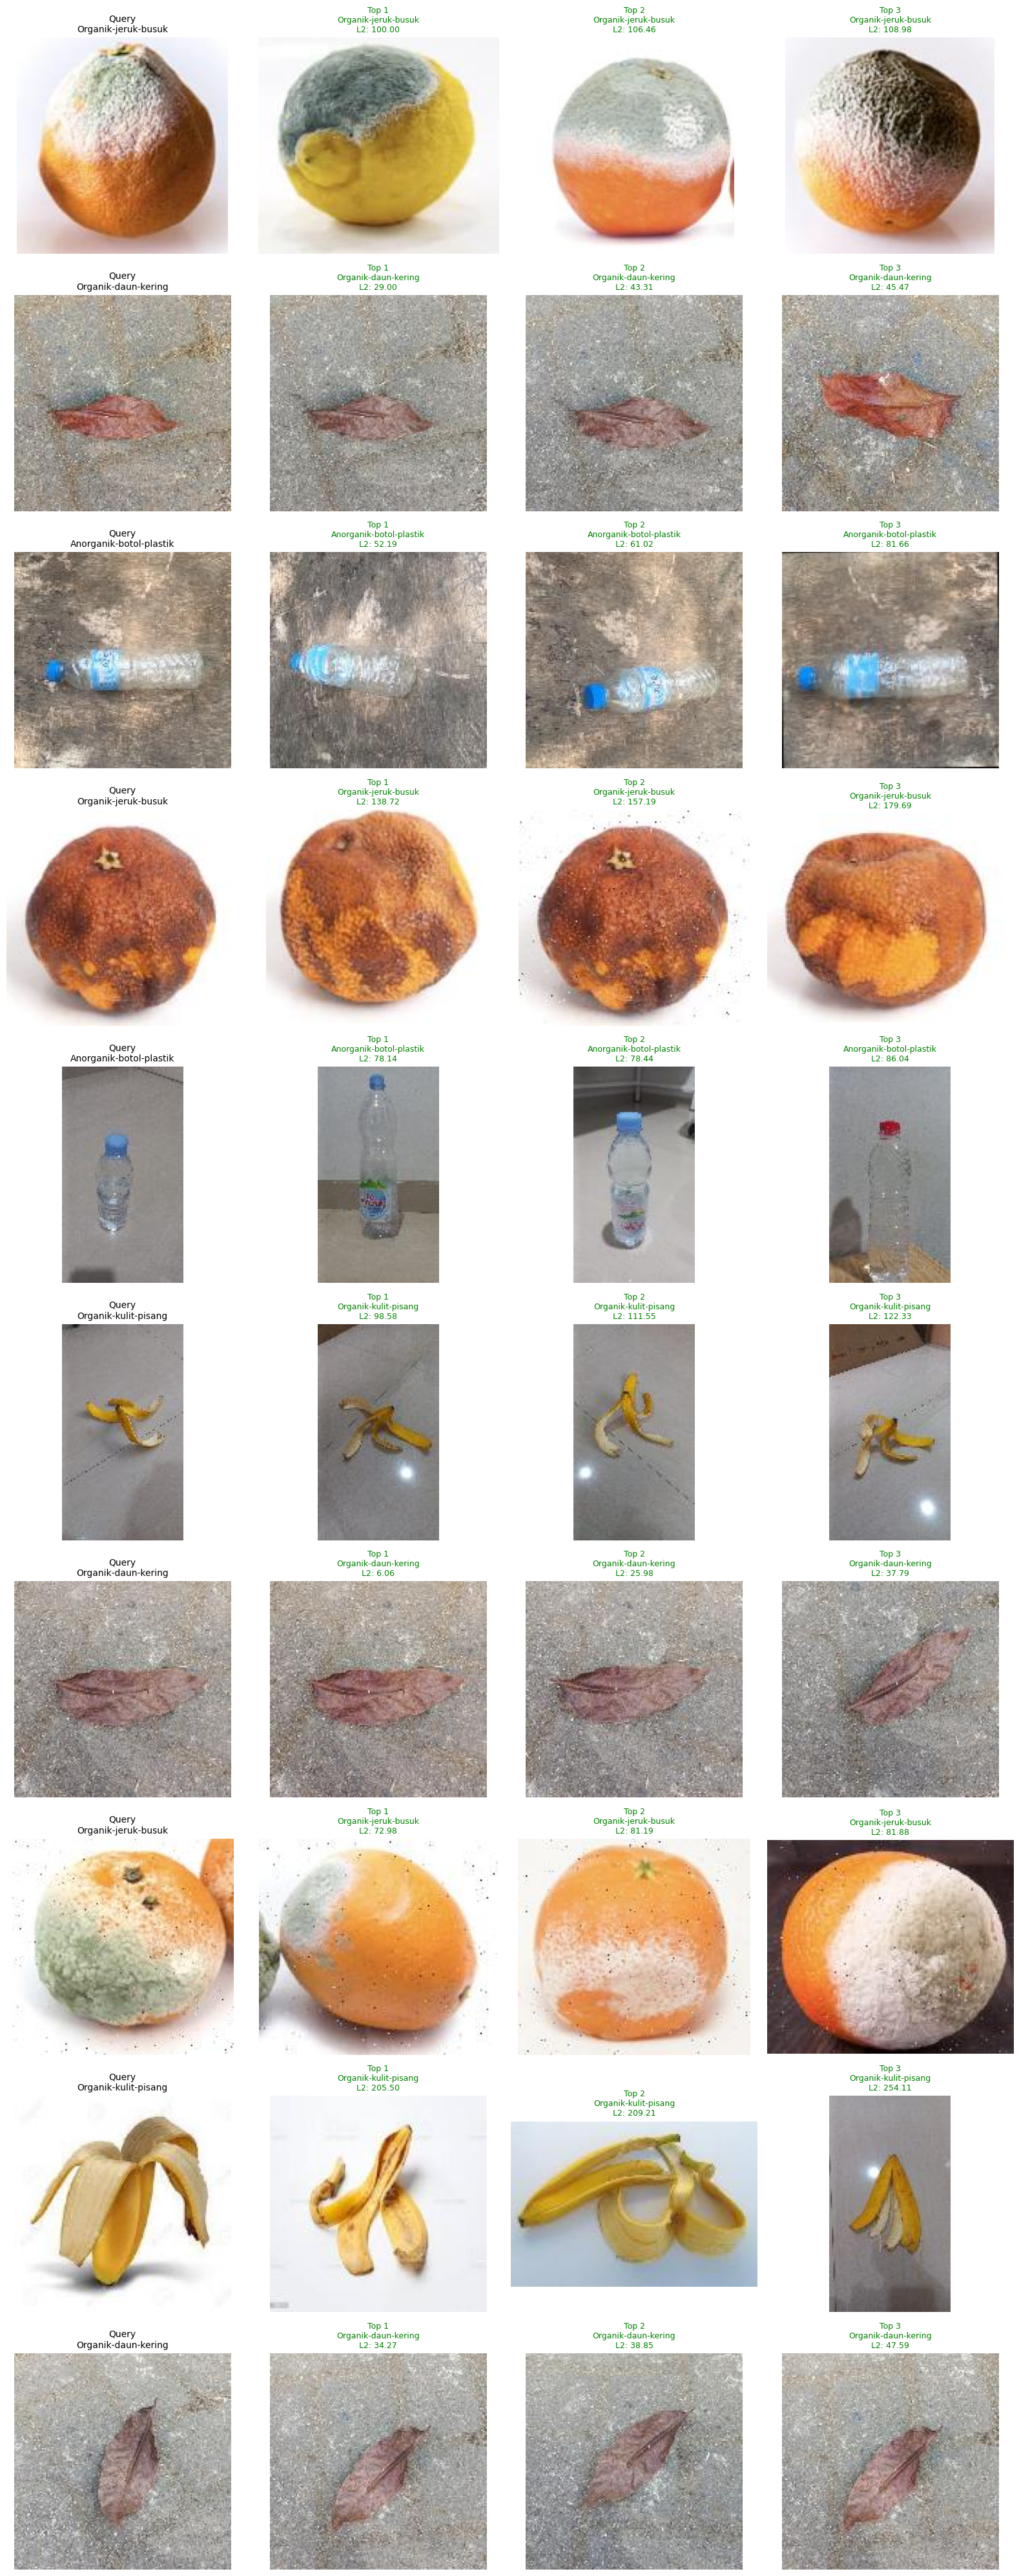

In [13]:
# ========== 5. RUN PIPELINE ==========
# Set lokasi data di Google Drive atau Colab local
base_path = "/content/dataset"  # ubah sesuai lokasi unzip

df_train = load_onehot_df(os.path.join(base_path, 'train'))
df_test = load_onehot_df(os.path.join(base_path, 'test'))

print("\n🚀 Ekstraksi fitur TRAIN")
train_feats, train_labels, train_paths = extract_features(df_train)

print("\n🚀 Ekstraksi fitur TEST")
test_feats, test_labels, test_paths = extract_features(df_test)

# Evaluasi dan visualisasi
evaluate_and_visualize_cached(
    test_feats, test_labels, test_paths,
    train_feats, train_labels, train_paths,
    top_k=3, sample_size=10
)

# Export Model to ONNX

In [16]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 47.4 MB/s eta 0:00:00


In [22]:
# ========== 1. LOAD & MODIFY RESNET MODEL ==========
print("[INFO] Loading ResNet50...")
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove FC
model.eval()

[INFO] Loading ResNet50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [23]:
# ========== 2. EXPORT TO ONNX ==========
print("[INFO] Exporting model to ONNX...")
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(
    model,
    dummy_input,
    "resnet50_feature_extractor.onnx",
    input_names=["input"],
    output_names=["feature"],
    dynamic_axes={"input": {0: "batch_size"}, "feature": {0: "batch_size"}},
    opset_version=11
)
print("✅ Model ONNX disimpan sebagai 'resnet50_feature_extractor.onnx'")

[INFO] Exporting model to ONNX...
✅ Model ONNX disimpan sebagai 'resnet50_feature_extractor.onnx'


In [24]:
print("[INFO] Building FAISS index...")
index = faiss.IndexFlatL2(2048)
index.add(train_feats.astype('float32'))


[INFO] Building FAISS index...


In [25]:
print("[INFO] Saving FAISS index to 'faiss.index'")
faiss.write_index(index, "faiss.index")

[INFO] Saving FAISS index to 'faiss.index'


In [26]:
print("[INFO] Saving train labels to 'train_labels.npy'")
np.save("train_labels.npy", train_labels)

[INFO] Saving train labels to 'train_labels.npy'


In [27]:
print("[INFO] Saving train paths to 'train_paths.npy'")
np.save("train_paths.npy", train_paths)

[INFO] Saving train paths to 'train_paths.npy'
